In [1]:
# imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import skimage.color
import skimage.filters
import skimage.io
import skimage.feature
import skimage.measure
import skimage.color
%matplotlib inline

### Utility functions

In [2]:
# Scaling or clipping
scale = lambda x : (255 * (x - np.min(x))) / (np.max(x) - np.min(x))
inrange = lambda x: np.where(x > 255, 255, np.where(x < 0, 0, x))
invert = lambda x: np.max(x) - x
print_range = lambda x: print(np.min(x), np.max(x))

### Image input and pre processing

In [3]:
input_texture = cv2.imread('../images/input.png')
input_texture = cv2.cvtColor(input_texture, cv2.COLOR_BGR2RGB)

In [4]:
# inp2=cv2.imread('../images/texture2.png')
# inp2=cv2.cvtColor(inp2,cv2.COLOR_BGR2RGB)
inp2 = np.copy(input_texture)

In [5]:
def apply_filter(im, filt, zero_padding=False):
    
    wdth = filt.shape[0]//2
    
    filt_img = np.zeros(im.shape)
    
    if zero_padding:
        im = np.vstack( (np.zeros( (wdth, im.shape[1]) ), im, np.zeros( (wdth, im.shape[1]) ) ) )
        im = np.hstack( (np.zeros( (im.shape[0], wdth) ), im, np.zeros( (im.shape[0], wdth) ) ) )
    else:
        im = np.vstack(([im[0]]*wdth, im, [im[-1]]*wdth))
        im = np.hstack((np.hstack([im[:,0].reshape(-1,1)]*wdth), im, np.hstack([im[:,-1].reshape(-1,1)]*wdth)))

    for i in range(wdth, im.shape[0]-wdth):
        for j in range(wdth, im.shape[1]-wdth):
            filt_img[i-wdth][j-wdth] = np.sum(im[i-wdth:i+wdth+1, j-wdth:j+wdth+1] * filt)
    
    return np.rint(filt_img)

prewitt =  [np.array([
                [-1, 0, 1],
                [-1, 0, 1],
                [-1, 0, 1]
        ]) , np.array([
                [ 1,  1,  1],
                [ 0,  0,  0],
                [-1, -1, -1]
        ])]


In [6]:
def decouple(img):
    
    img = img.astype('float64')
    
    with np.errstate(divide='ignore', invalid='ignore'):
        intensity_layer = np.nan_to_num(np.true_divide(((img[:, :, 0]**2) + (img[:, :, 1]**2) + (img[:, :, 2]**2)) , (img[:,:,0]+img[:, :, 1]+img[:, :, 2])))
        intensity_layer = np.rint(intensity_layer).astype('uint8')
        dx = apply_filter(intensity_layer, prewitt[0])
        dy = apply_filter(intensity_layer, prewitt[1])
        gradient = np.nan_to_num(np.arctan(dy/dx)) 

    
    return intensity_layer,gradient

In [7]:
details, gradient = decouple(input_texture)

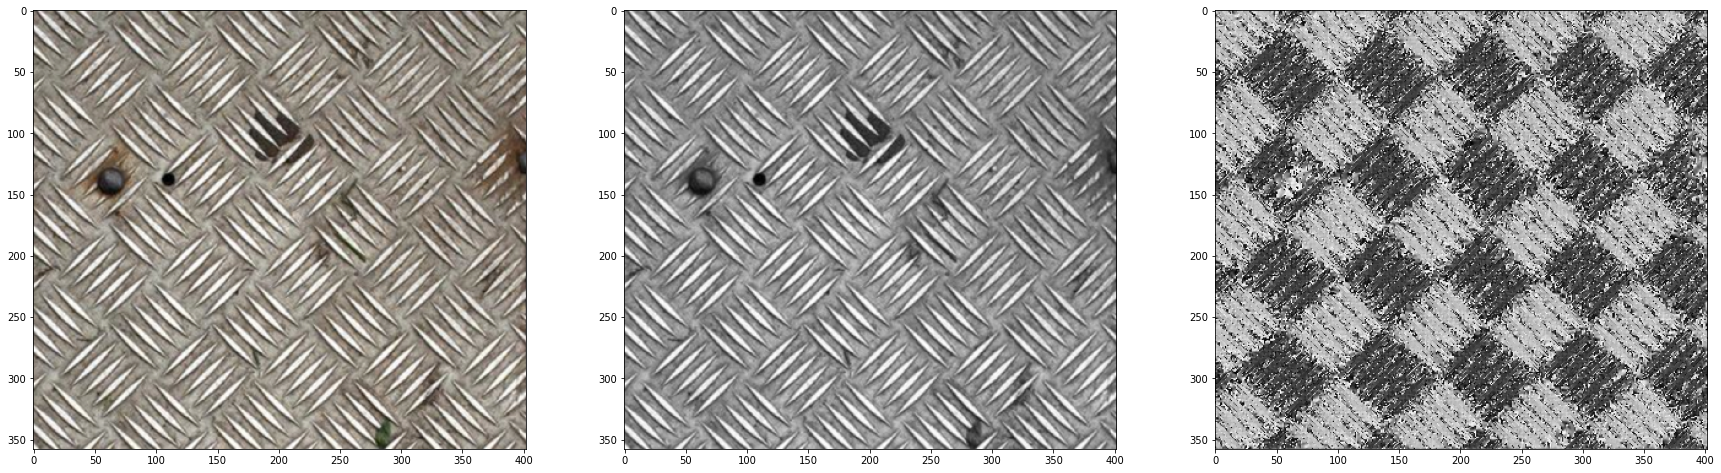

In [8]:
plt.figure(figsize = (30, 30))

plt.subplot(131)
plt.imshow(input_texture, cmap='gray')

plt.subplot(132)
plt.imshow(details, cmap='gray')

plt.subplot(133)
plt.imshow(gradient, cmap='gray')

plt.show()

## Distance function

In [9]:
def distance(sI, sG, tI, tG):

    M, N = tI.shape
    
    Y, X = sI.shape
    wdth_y, wdth_x = Y//2, X//2

    tI = np.vstack(([tI[0]]*wdth_y, tI, [tI[-1]]*(Y-wdth_y)))
    tI = np.hstack((np.hstack([tI[:,0].reshape(-1,1)]*wdth_x), tI, np.hstack([tI[:,-1].reshape(-1,1)]*(X-wdth_x))))

    tG = np.vstack(([tG[0]]*wdth_y, tG, [tG[-1]]*(Y-wdth_y)))
    tG = np.hstack((np.hstack([tG[:,0].reshape(-1,1)]*wdth_x), tG, np.hstack([tG[:,-1].reshape(-1,1)]*(X-wdth_x))))
   
    g_img = np.zeros((M, N))
    l_img = np.zeros((M, N))
   
    for i in range(wdth_y, wdth_y+M):
        for j in range(wdth_x, wdth_x+N):
            try:
                g_img[i-wdth_y ,j-wdth_x] = np.average(np.abs(sG - tG[i-wdth_y:i+Y-wdth_y, j-wdth_x:j+X-wdth_x]))
                l_img[i-wdth_y ,j-wdth_x] = np.average(np.abs(sI - tI[i-wdth_y:i+Y-wdth_y, j-wdth_x:j+X-wdth_x]))
            except Exception:
                print("Source shape: ", sG.shape, "  i, j:", i, j, "   Patch shape:",  tG[i-wdth_y:i+Y-wdth_y, j-wdth_x:j+X-wdth_x].shape)
                raise Exception
            
    return (g_img / np.max(g_img)) + (l_img / np.max(l_img))

In [10]:
def inbuilt_distance(sI, sG, tI, tG):

    M, N = tI.shape
    
    Y, X = sI.shape
    wdth_y, wdth_x = Y//2, X//2
    try:
        if wdth_y:
            tI = np.vstack(([tI[0]]*wdth_y, tI))
            tG = np.vstack(([tG[0]]*wdth_y, tG))
        if Y-wdth_y-1:
            tI = np.vstack((tI, [tI[-1]]*(Y-wdth_y-1)))
            tG = np.vstack((tG, [tG[-1]]*(Y-wdth_y-1)))
        
        if wdth_x:
            tI = np.hstack((np.hstack([tI[:,0].reshape(-1,1)]*wdth_x), tI))
            tG = np.hstack((np.hstack([tG[:,0].reshape(-1,1)]*wdth_x), tG))
        if X-wdth_x-1:
            tI = np.hstack((tI, np.hstack([tI[:,-1].reshape(-1,1)]*(X-wdth_x-1))))
            tG = np.hstack((tG, np.hstack([tG[:,-1].reshape(-1,1)]*(X-wdth_x-1))))
            
    except Exception:
        print("\n", wdth_x, wdth_y, Y-wdth_y-1, X-wdth_x-1)
        raise Exception   

    lum = cv2.matchTemplate(tI,sI, cv2.TM_CCOEFF_NORMED)
    grd = cv2.matchTemplate(np.rint(scale(tG)).astype('uint8'), np.rint(scale(sG)).astype('uint8'), cv2.TM_CCOEFF_NORMED)
    
    return invert(lum+grd)

In [11]:
def median_filter(im, k):
        
    filt_img = np.zeros(im.shape)

    wdth = k//2

    im = np.vstack(([im[0]]*wdth, im, [im[-1]]*(k-wdth)))
    im = np.hstack((np.hstack([im[:,0].reshape(-1,1)]*wdth), im, np.hstack([im[:,-1].reshape(-1,1)]*(k-wdth))))

    for j in range(wdth, im.shape[1]-wdth):
        for i in range(wdth, im.shape[0]-wdth):
            x = np.median(im[i-wdth:i+k-wdth+1, j-wdth:j+k-wdth+1])
            filt_img[i-wdth][j-wdth] = x
    return filt_img

## Age Map function

In [12]:
def age(source_patch, target, K):
    
    sI, sG = source_patch
    tI, tG = target
    dist_mat = inbuilt_distance(sI, sG, tI, tG)
#     discrete = np.rint(scale(dist_mat)).astype('uint8')
    # discrete = median_filter(discrete, sI.shape[0]//2 + sI.shape[0]%2 - 1)
#     size = sI.shape[0]//2
#     size = max(1, size + (1-(size%2)))
#     discrete = cv2.medianBlur(discrete, size)

    K_distances = np.sort(dist_mat.flatten())[:K]
#     K_distances = np.sort(np.unique(discrete).flatten())[:K]
#     co_ords = []
#     for i in K_distances:
#         x, y = np.where(discrete == i)
#         for j in zip(x, y):
#             co_ords.append(j)

#     K_neighbours = [dist_mat[x, y] for (x, y) in co_ords]
#     K_neighbours = [dist_mat[x, y] for (x, y) in co_ords]

#     return np.average(K_neighbours)
    return np.average(K_distances)



In [13]:
def generate_age_map(I, G, N, K):

    age_map = np.zeros(I.shape, dtype=('float64'))

    for i in range(0, I.shape[0], N):
        for j in range(0, I.shape[1], N):
            x1, x2 = i, min(I.shape[0], i+N)
            y1, y2 = j, min(I.shape[1], j+N)
            age_map[x1:x2, y1:y2] = age( (I[x1:x2, y1:y2], G[x1:x2, y1:y2]) , (I, G), K)

    return age_map


## Colormap

In [14]:
import matplotlib.colors as mcolors


def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

c = mcolors.ColorConverter().to_rgb

heatmap = make_colormap(
    [c('blue'), c('aqua'), 0.33, c('aqua'), c('yellow'), 0.66, c('yellow'), c('red')])

# Testing for age map

#### Temp

In [15]:
N = 20
# x=205-5
# y=70+6
x=0
y=0

In [16]:
source_patch_one = input_texture[x:x+N, y:y+N, :]
source_patch_l = details[x:x+N, y:y+N]
source_patch_g = gradient[x:x+N, y:y+N]

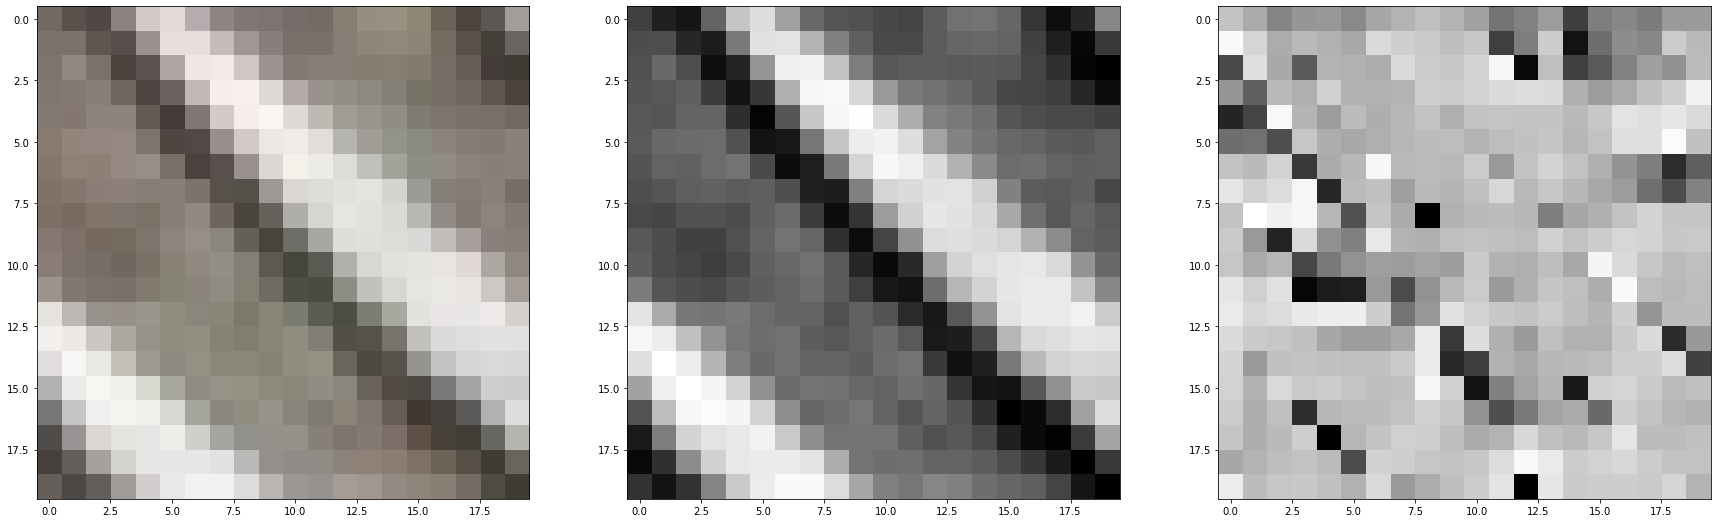

In [17]:
plt.figure(figsize = (30, 30))

plt.subplot(131)
plt.imshow(source_patch_one, cmap='gray')

plt.subplot(132)
plt.imshow(source_patch_l, cmap='gray')

plt.subplot(133)
plt.imshow(source_patch_g, cmap='gray')

plt.show()

In [18]:
%%time
for_2_inbuilt = inbuilt_distance(source_patch_l, source_patch_g, details, gradient)

CPU times: user 8.33 ms, sys: 2.47 ms, total: 10.8 ms
Wall time: 9.34 ms


In [19]:
b = np.rint(scale(for_2_inbuilt)).astype('uint8')
med = cv2.medianBlur(b, 9)
# med = cv2.erode(b, np.ones((9, 9), dtype='int'))

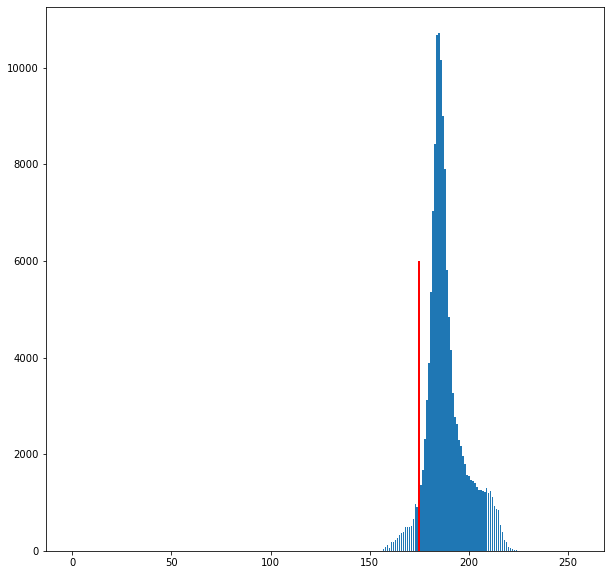

In [20]:
plt.figure(figsize=(10, 10))
plt.bar(range(256), np.bincount(med.flatten(), minlength=256))
plt.bar(range(256), [6000 if i==175 else 0 for i in range(256)], color='red')
plt.show()

In [21]:
print_range = lambda x: print(np.min(x), np.max(x))

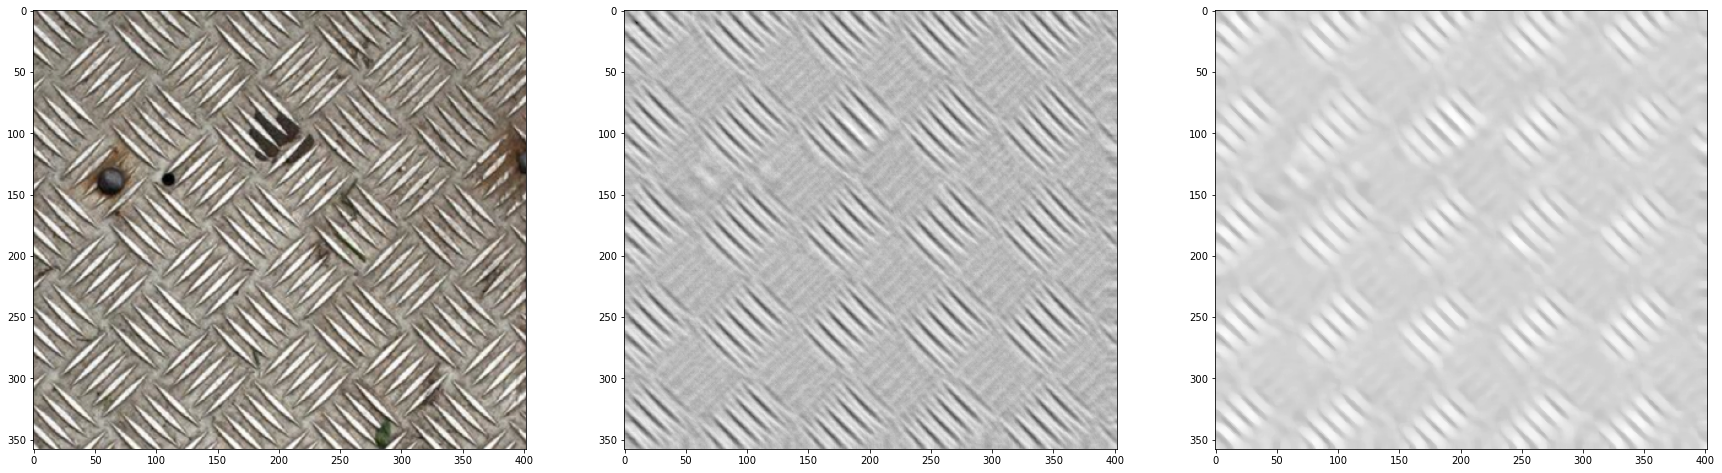

In [22]:
plt.figure(figsize=(30, 10))

plt.subplot(131).imshow(input_texture, cmap='gray')
plt.subplot(132).imshow(b, cmap='gray')
plt.subplot(133).imshow(med, cmap='gray', vmin=0)

plt.show()

In [23]:
K2_distances = np.sort(for_2_inbuilt.flatten())

In [24]:
K2_distances

array([0.        , 0.6955215 , 0.71779954, ..., 2.744288  , 2.7514539 ,
       2.7540228 ], dtype=float32)

In [25]:
(np.mean(K2_distances[:int(0.002*len(K2_distances))]))

0.91048586

In [26]:
# co_ords2 = np.array([[-1, -1]])
# d = 0
# for i in K2_distances:
#     x, y = np.where(med==i)
#     flag=False
#     for j in zip(x, y):
#         if not np.any(np.abs(co_ords2[1:] - j) < [15, 15]):
#             co_ords2 = np.vstack((co_ords2, np.array(j)))
#             flag=True
#     if flag: 
#         d = d+1
#     if d == 10:
#         break
        

In [27]:
# print(co_ords2[:])

In [28]:
# K2_neighbours = [for_2_inbuilt[x, y] for (x, y) in co_ords2[1:]]
# K2_neighbours2 = [b[x, y] for (x, y) in co_ords2[1:]]

In [29]:
# print(np.average(K2_neighbours), np.average(K2_neighbours2))

In [30]:
# for (i, j) in co_ords2:
#     min_x = max(i-10, 0)
#     min_y = max(j-10, 0)
#     max_x = min(i+11, input_texture.shape[0])
#     max_y = min(j+11, input_texture.shape[1])
#     plt.figure(figsize=(20, 20))
#     plt.subplot(121)
#     plt.imshow(source_patch_one)
#     plt.title("original")

#     plt.subplot(122)
#     plt.imshow(input_texture[min_x:max_x, min_y:max_y])
#     plt.title(f"{min_x}:{max_x}, {min_y}:{max_y}")
#     plt.show()

### Final

In [31]:
%%time
age_map = generate_age_map(details, gradient, 20, 100)

CPU times: user 6.75 s, sys: 187 ms, total: 6.94 s
Wall time: 6.94 s


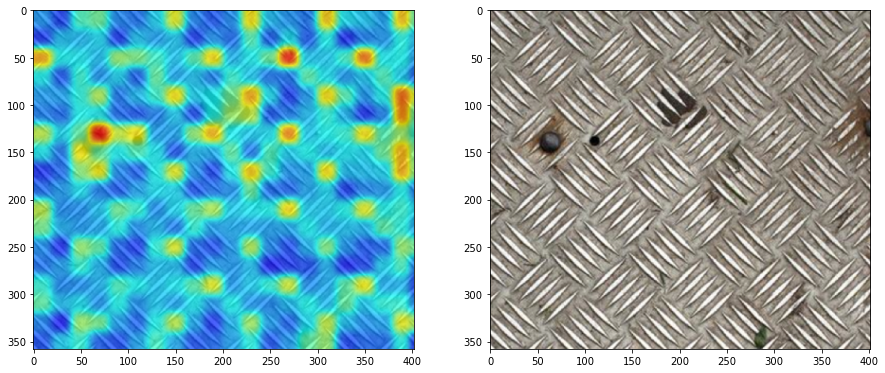

In [32]:
plt.figure(figsize=(15, 15))
plt.subplot(121)
# plt.imshow(age_map, cmap=heatmap, alpha=1)
plt.imshow(cv2.GaussianBlur(age_map,(25, 25),0), cmap=heatmap, alpha=1)
plt.imshow(input_texture, alpha=0.3)
# plt.colorbar()
plt.subplot(122)
plt.imshow(input_texture)
plt.show()

In [33]:
%%time
details2, gradient2 = decouple(inp2)
age_map2 = generate_age_map(details2, gradient2, 20, 100)

CPU times: user 9.37 s, sys: 271 ms, total: 9.64 s
Wall time: 9.73 s


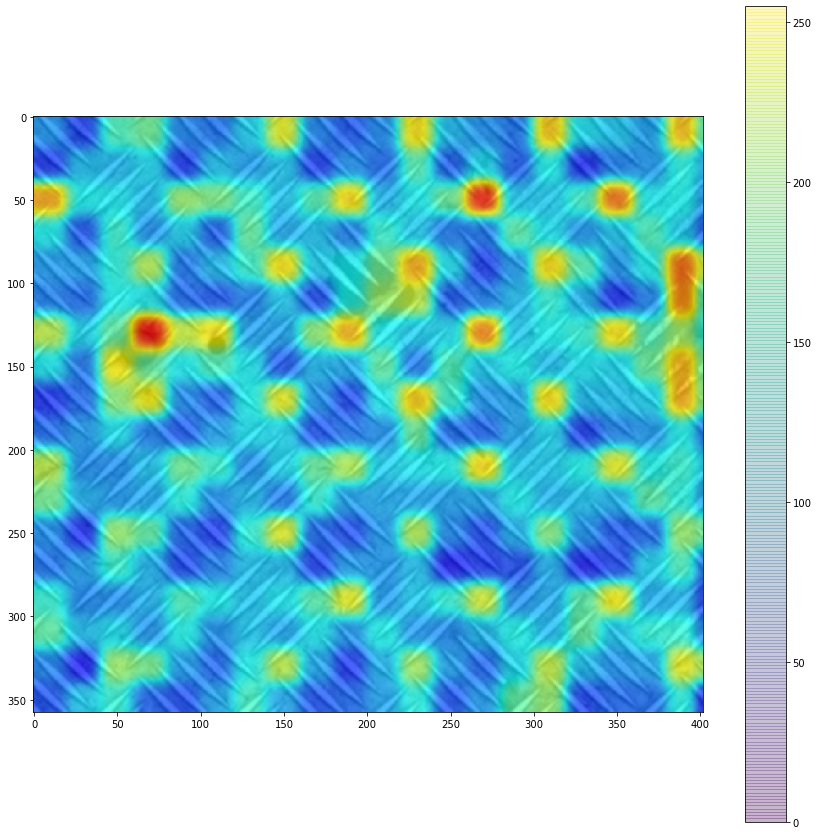

In [34]:
plt.figure(figsize=(15, 15))
# plt.imshow(age_map2, cmap=heatmap, alpha=1)
plt.imshow(cv2.GaussianBlur(age_map2,(23, 23),0), cmap=heatmap, alpha=1)
plt.imshow(inp2, alpha=0.3)
plt.colorbar()
plt.show()

# Tile detection 

In [17]:
a,b,c=input_texture.shape

N = a//4

source_patch_one = input_texture[a//4:a//4+N,b//4:b//4+N, :]
source_patch_l = details[a//4:a//4+N,b//4:b//4+N]
source_patch_g = gradient[a//4:a//4+N,b//4:b//4+N]


In [18]:
%%time
dist_map = inbuilt_distance(source_patch_l, source_patch_g, details, gradient)

CPU times: user 41.8 ms, sys: 4.42 ms, total: 46.3 ms
Wall time: 43.3 ms


(-0.5, 401.5, 357.5, -0.5)

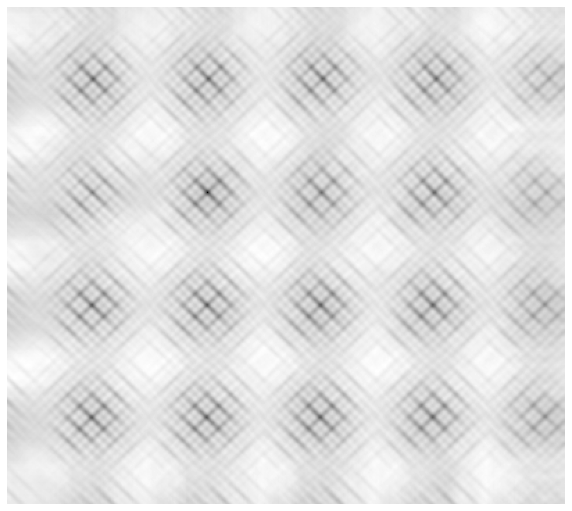

In [19]:
plt.figure(figsize=(10,10))
plt.imshow(dist_map ,cmap='gray')
plt.axis('off')

In [20]:
def local_minimas(dist_map,N):
    
    a,b=dist_map.shape
    minima=np.zeros((a,b),dtype='uint8')
    for i in range(0,a,N):
        for j in range(0,b,N):
            X=min(i+N,a)
            Y=min(j+N,b)
            patch=dist_map[i:X,j:Y]
            thresh=np.unique(patch)[np.rint(0.005*(X-i)*(Y-j)).astype('uint8')]
#             plt.figure(figsize=(10,10))
#             plt.imshow(patch<thresh,cmap='gray')
#             plt.axis('off')
            minima[i:X,j:Y]=patch<thresh     
                      
    return minima.astype('uint8')                  
                      
                      
                      
                     


In [21]:
def global_minimas(dist_map):
    
    a,b=dist_map.shape
    minima=np.zeros((a,b),dtype='uint8')
    
    thresh=np.unique(dist_map)[np.rint(0.005*(a-1)*(b-1)).astype('uint8')]
#   plt.figure(figsize=(10,10))
#   plt.imshow(patch<thresh,cmap='gray')
#   plt.axis('off')
    minima=dist_map<thresh     
                      
    return minima.astype('uint8')                  
                      

In [22]:
global_mask=global_minimas(dist_map)

In [23]:
# plt.figure(figsize=(10,10))
# plt.imshow(input_texture)
# plt.axis('off')
# plt.show()
# plt.figure(figsize=(20,20))
# plt.subplot(121)
# plt.imshow(local_mask,cmap='gray')
# plt.axis('off')
# plt.subplot(122)
# plt.imshow(global_mask,cmap='gray')
# plt.axis('off')
# plt.show()

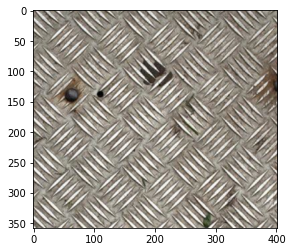

In [24]:
plt.imshow(inp2)

In [25]:
details2, gradient2 = decouple(inp2)

In [26]:
a,b,c=inp2.shape

N2 = a//4

source_patch_one = inp2[a//4:a//4+N2,b//4:b//4+N2, :]
source_patch_l = details2[a//4:a//4+N2,b//4:b//4+N2]
source_patch_g = gradient2[a//4:a//4+N2,b//4:b//4+N2]


dist_map2 = inbuilt_distance(source_patch_l, source_patch_g, details2, gradient2)

(-0.5, 401.5, 357.5, -0.5)

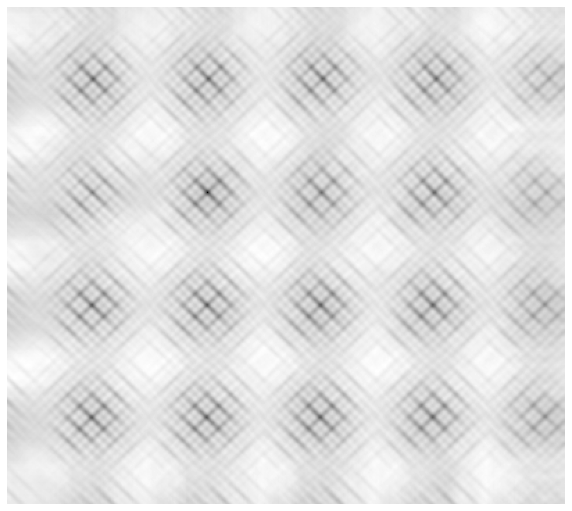

In [27]:
plt.figure(figsize=(10,10))
plt.imshow(dist_map2,cmap='gray')
plt.axis('off')

In [28]:
g1=global_minimas(dist_map)
g2=global_minimas(dist_map2)

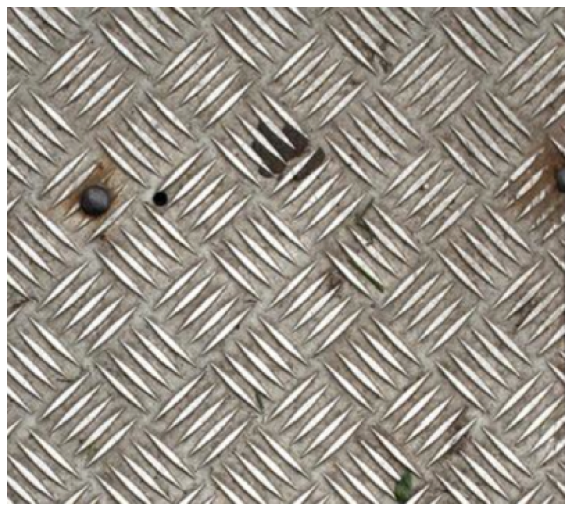

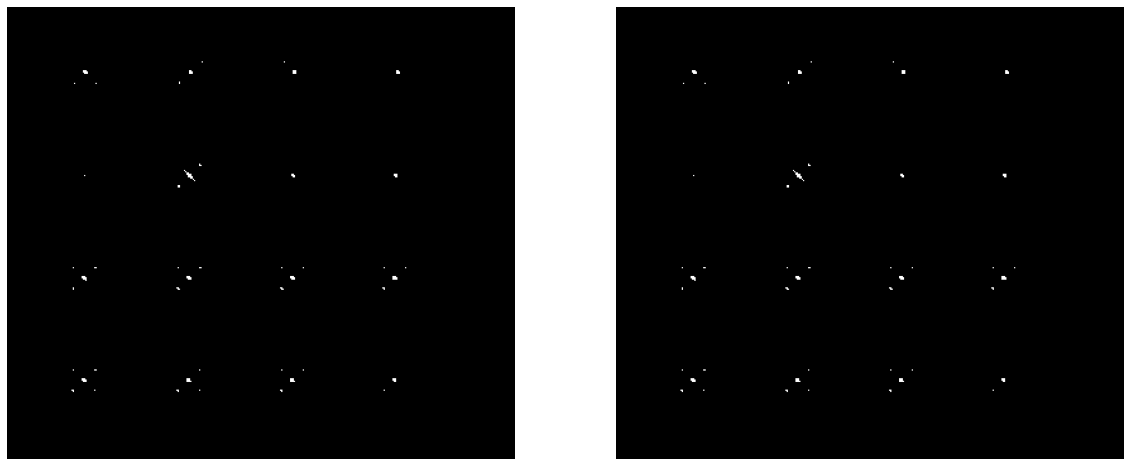

In [29]:
plt.figure(figsize=(10,10))
plt.imshow(inp2)
plt.axis('off')
plt.show()
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(g1,cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(g2,cmap='gray')
plt.axis('off')
plt.show()

In [30]:
g1_bin= cv2.threshold(g1, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
g2_bin= cv2.threshold(g2, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

ret1, labels1 = cv2.connectedComponents(g1_bin)
ret2, labels2 = cv2.connectedComponents(g2_bin)



In [31]:
def make_tile(luminance, gradient,labels):
    a,b=luminance.shape
    N1=a//4
    N2=b//4
    check=np.unique(labels)[1:]
    tiles={}
    global_min={}
#     dummy={}
    
    for i in check:
#         dummy_i=np.zeros((a,b),dtype='uint8')
        temp=np.where(labels==i)
        l=len(temp[0])
        x=temp[0][l//2]
        y=temp[1][l//2]
        grad_tile=gradient[ max(0,x-N1//2):min(x+N1//2,a-1) , max(0,y-N2//2):min(b-1,y+N2//2) ]
        lum_tile=luminance[ max(0,x-N1//2):min(x+N1//2,a-1) , max(0,y-N2//2):min(b-1,y+N2//2) ]
#         print(lum_tile.shape,' ' , grad_tile.shape, ' ', a,b)
#         print(max(0,x-N//2),":",min(x+N//2,a-1) ,"      ", max(0,y-N//2),":",min(b-1,y+N//2))
#         dummy_i[ max(0,x-N//2):min(x+N//2,a-1) , max(0,y-N//2):min(b-1,y+N//2) ]=1
        tiles[i]=inbuilt_distance(lum_tile, grad_tile, luminance, gradient)
        global_min[i]=global_minimas(tiles[i])
#         dummy[i]=dummy_i
    return global_min

In [32]:

details, gradient = decouple(input_texture)
pot_tiles1=make_tile(details,gradient,labels1)

In [33]:
def sum_tiles(pot_tiles):
    a,b=pot_tiles[1].shape
    sum_tiles=np.zeros((a,b),dtype='uint8')
    for i in pot_tiles:
        sum_tiles+=pot_tiles[i]
    return sum_tiles    

In [34]:
%%time
pot_tiles2=make_tile(details2,gradient2,labels2)

CPU times: user 1.59 s, sys: 2.79 ms, total: 1.59 s
Wall time: 1.59 s


In [35]:
sum_tiles1=sum_tiles(pot_tiles1)    
sum_tiles2=sum_tiles(pot_tiles2)    


In [64]:
def detect_peaks_local(sum_tiles):
    a,b= sum_tiles.shape
    N1=(a)//4
    N2=b//4
    maxima = np.zeros((a,b),dtype='uint8')
    for i in range(0,a,N1):
        for j in range(0,b,N2):
            X=min(i+N1,a)
            Y=min(j+N2,b)
            patch=sum_tiles[i:X,j:Y]
            thresh = np.max(patch)

            if thresh > 0:
                maxima[i:X,j:Y] = patch == thresh
                maxima[maxima == 1] = 255
            else:
                maxima[i:X,j:Y] = patch
#     print('a//3:',a//3,'b//3',b//3)            
    return N1,N2,maxima.astype('uint8')                  

#     se = np.ones((N,N))
#     peak_coords = skimage.morphology.local_maxima(sum_tiles,se)
#     print(peak_coords)
#     return peak_coords


    ## Using skimage local maxima gives errors as dimension of structuring element does not match with image. 
    ## Without SE , multiple local maximas are getting detected. Rectifying might give better results than local minima code.

a//3: 119 b//3 134
(array([ 51,  51,  51,  51,  52, 133, 133, 133, 133, 133, 133, 214, 214,
       214, 214, 214, 295, 295, 295, 295]), array([ 62, 145, 227, 309,  62,  61,  62, 144, 226, 307, 308,  61, 144,
       226, 306, 307,  61, 143, 225, 307]))


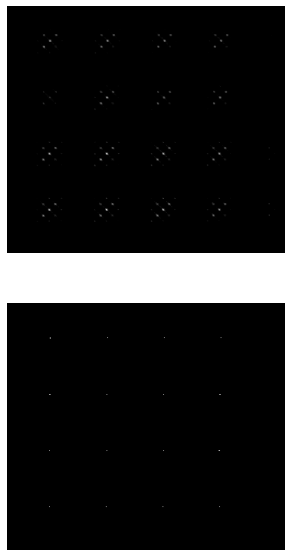

In [37]:
N1,N2,final_tile_centers1 = detect_peaks_local(sum_tiles1)

# print(sum_tiles[sum_tiles!=0])
print(np.nonzero(final_tile_centers1))
# print(len(final_tile_centers))
final_tile_centers1[final_tile_centers1!=0] = 255
fig,ax = plt.subplots(2,figsize=(10,10))
ax[0].axis('off')
ax[1].axis('off')
ax[0].imshow(sum_tiles1 , cmap = 'gray')
ax[1].imshow(final_tile_centers1, cmap= 'gray')

a//3: 119 b//3 134
(array([ 51,  51,  51,  51,  52, 133, 133, 133, 133, 133, 133, 214, 214,
       214, 214, 214, 295, 295, 295, 295]), array([ 62, 145, 227, 309,  62,  61,  62, 144, 226, 307, 308,  61, 144,
       226, 306, 307,  61, 143, 225, 307]))


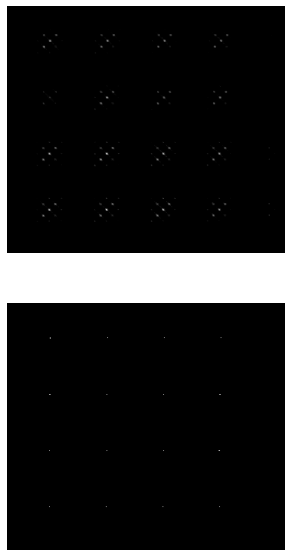

In [38]:
N1,N2,final_tile_centers2 = detect_peaks_local(sum_tiles2)

# print(sum_tiles[sum_tiles!=0])
print(np.nonzero(final_tile_centers2))
# print(len(final_tile_centers))
final_tile_centers2[final_tile_centers2!=0] = 255
fig,ax = plt.subplots(2,figsize=(10,10))
ax[0].axis('off')
ax[1].axis('off')
ax[0].imshow(sum_tiles2 , cmap = 'gray')
ax[1].imshow(final_tile_centers2, cmap= 'gray')

In [39]:
## Finding the Offset Vectors
def grid_calc(final_tile_centers):
    Tile_centers = []
    x,y = np.nonzero(final_tile_centers)[0],np.nonzero(final_tile_centers)[1]

    for c in range(x.shape[0]):
        Tile_centers.append([x[c] , y[c]])
    Tile_centers = np.array(Tile_centers)
    Offset_Vectors = []
    for i in range(Tile_centers.shape[0]):
        for j in range(i+1,Tile_centers.shape[0]):
                Offset_Vectors.append(Tile_centers[i]- Tile_centers[j])
    # Offset_Vectors = np.array(Offset_Vectors)
    u,c = np.unique(Offset_Vectors,axis = 0, return_counts=True)
    sorted_arr = u[c.argsort()]
#     print(sorted_arr[-50:])
   
        
    v=abs(sorted_arr)
    v=v[ np.where( np.any([np.all(v >= [N1/2, N2/2], axis=1), np.logical_and(v[:, 0] == 0, v[:, 1] >= N2/2), np.logical_and(v[:, 0] >= N1/2, v[:, 1] == 0)], axis=0 ) ) ]
    x,y,x_sum,y_sum = 0,0,0,0
   
    for i in range(1, len(v)+1):
        tempx, tempy = v[-i]
        if tempx:
            x += 1
            x_sum += tempx
        if tempy:
            y+=1
            y_sum += tempy

        if x and y:
            x = np.rint(x_sum/x).astype('int64')
            y = np.rint(y_sum/y).astype('int64')

            break
    return x,y   


In [40]:
# v=abs(sorted_arr)
# # print(v)
# v=v[ np.where( np.any([np.all(v >= [N1/2, N2/2], axis=1), np.logical_and(v[:, 0] == 0, v[:, 1] >= N2/2), np.logical_and(v[:, 0] >= N1/2, v[:, 1] == 0)], axis=0 ) ) ]
# print(N1,N2,v[-2:])

In [41]:
# x = 0
# y = 0
# x_sum= 0
# y_sum = 0
# for i in range(1, len(v)+1):
#     tempx, tempy = v[-i]
#     if tempx:
#         x += 1
#         x_sum += tempx
#     if tempy:
#         y+=1
#         y_sum += tempy

#     if x and y:
#         x = np.rint(x_sum/x).astype('int64')
#         y = np.rint(y_sum/y).astype('int64')
        
#         break

In [42]:
# print(x,y)

In [43]:
x1,y1=grid_calc(final_tile_centers1)
x2,y2=grid_calc(final_tile_centers2)

In [44]:
x1,y1

(81, 82)

In [45]:
x2,y2

(81, 82)

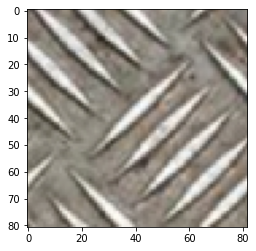

[ 0 : 81  ,  0 : 82 ]


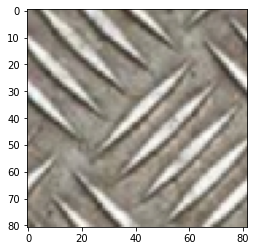

[ 0 : 81  ,  82 : 164 ]


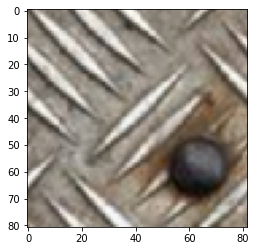

[ 81 : 162  ,  0 : 82 ]


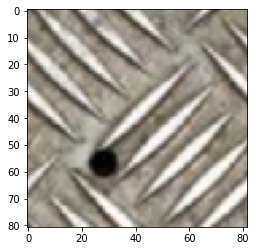

[ 81 : 162  ,  82 : 164 ]


In [46]:
c=0
for i in range(x1):
    c+=1
    if c>2:break
    d=0   
    for j in range(y1):
        d+=1
        if d>2:break       
        plt.imshow(input_texture[i*x1:(i+1)*x1,j*y1:(j+1)*y1])
        plt.show()
        print('[',i*x1,':',(i+1)*x1,' , ',j*y1,':',(j+1)*y1,']')
        

### Median Image

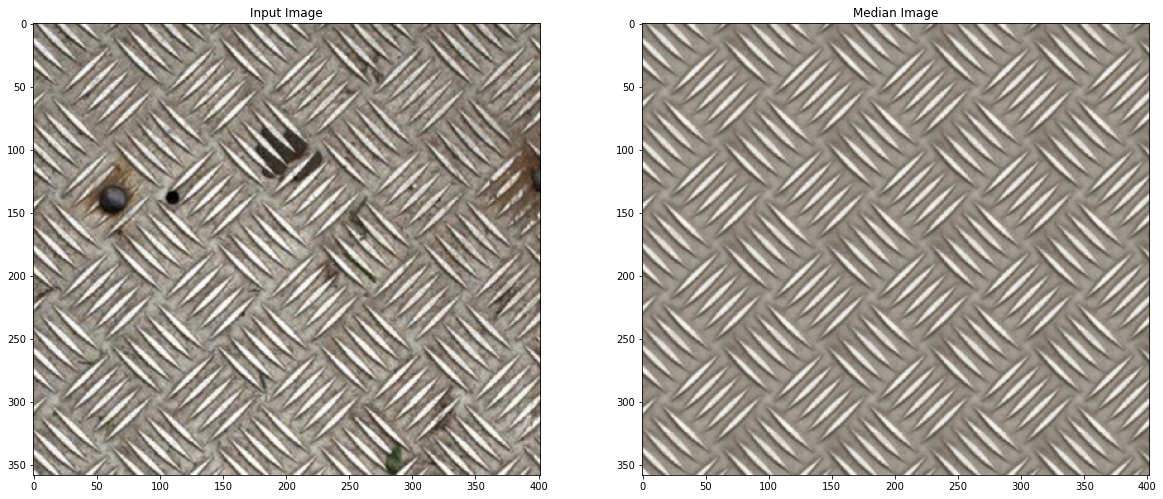

In [49]:
tiles = []

for i in range(x1):
    for j in range(y1):
        xi = i*x1
        xf = (i+1) * x1
        yi = j*y1
        yf = (j+1) * y1
        
        if (xf < input_texture.shape[0]) and (yf < input_texture.shape[1]):
            tiles.append(input_texture[xi:xf, yi:yf])

medianTile = np.rint(np.median(tiles, axis=(0)))
medianImage = np.copy(input_texture)

for i in range(x1):
    xi = i*x1
    xf = (i+1) * x1
    if xi >= medianImage.shape[0]:
        break
    for j in range(y1):
        yi = j*y1
        yf = (j+1) * y1
        
        if yi >= medianImage.shape[1]:
            break
        
        if (xf < medianImage.shape[0]) and (yf < medianImage.shape[1]):
            medianImage[xi:xf, yi:yf] = medianTile
        else:
            xf2 = min(xf, medianImage.shape[0])
            yf2 = min(yf, medianImage.shape[1])
            medianImage[xi:xf2, yi:yf2] = medianTile[:(xf2-xi), :(yf2-yi)]

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(input_texture)
plt.title("Input Image")
plt.subplot(122)
plt.imshow(medianImage)
plt.title("Median Image")
plt.show()

In [56]:
def median_image(input_texture,x1,y1): 
    tiles = []

    for i in range(x1):
        for j in range(y1):
            xi = i*x1
            xf = (i+1) * x1
            yi = j*y1
            yf = (j+1) * y1

            if (xf < input_texture.shape[0]) and (yf < input_texture.shape[1]):
                tiles.append(input_texture[xi:xf, yi:yf])

    medianTile = np.rint(np.median(tiles, axis=(0)))
    medianImage = np.copy(input_texture)

    for i in range(x1):
        xi = i*x1
        xf = (i+1) * x1
        if xi >= medianImage.shape[0]:
            break
        for j in range(y1):
            yi = j*y1
            yf = (j+1) * y1

            if yi >= medianImage.shape[1]:
                break

            if (xf < medianImage.shape[0]) and (yf < medianImage.shape[1]):
                medianImage[xi:xf, yi:yf] = medianTile
            else:
                xf2 = min(xf, medianImage.shape[0])
                yf2 = min(yf, medianImage.shape[1])
                medianImage[xi:xf2, yi:yf2] = medianTile[:(xf2-xi), :(yf2-yi)]
                
    return medianImage            

                
med_img=median_image(input_texture,x1,y1)   

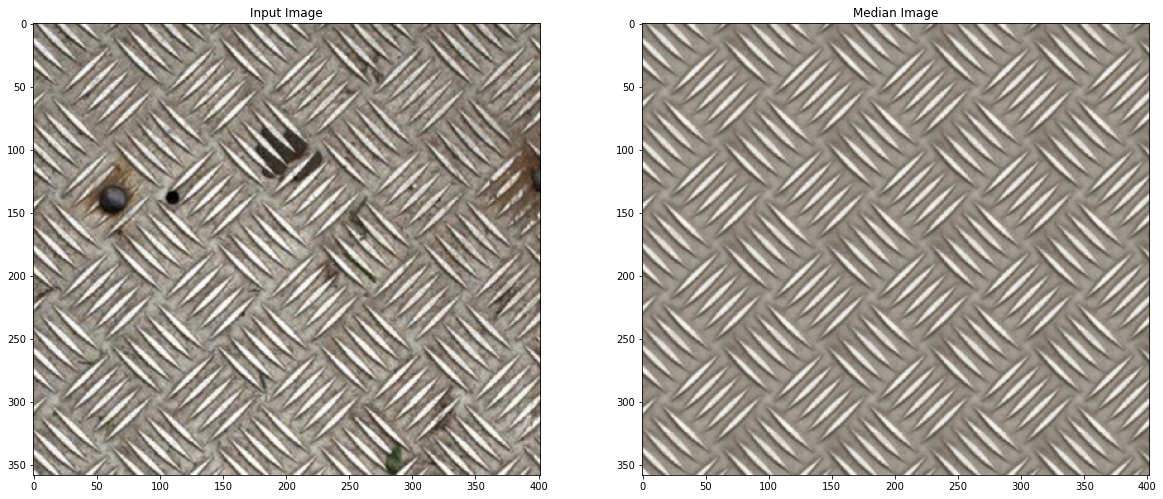

In [57]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(input_texture)
plt.title("Input Image")
plt.subplot(122)
plt.imshow(med_img)
plt.title("Median Image")
plt.show()

In [55]:
print(med_img)


None


In [65]:
def intact_texture(img_name):
    path='../images/'
    
    img=cv2.imread(path+img_name)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    a,b,c=img.shape
    N = a//4

    details, gradient = decouple(img)
    source_patch_one = img[a//4:a//4+N,b//4:b//4+N, :]
    source_patch_l = details[a//4:a//4+N,b//4:b//4+N]
    source_patch_g = gradient[a//4:a//4+N,b//4:b//4+N]

    dist_map = inbuilt_distance(source_patch_l, source_patch_g, details, gradient)
    
    g=global_minimas(dist_map)
    g_bin= cv2.threshold(g, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    ret, labels = cv2.connectedComponents(g_bin)
    
    pot_tiles=make_tile(details,gradient,labels)
    sum_=sum_tiles(pot_tiles)   
    
    N1,N2,final_tile_centers = detect_peaks_local(sum_)
    
    x,y=grid_calc(final_tile_centers)
    
    
    med_img=median_image(img,x,y)
    
    plt.figure(figsize=(20,20))
    plt.subplot(121)
    plt.imshow(img)
    plt.title("Input Image")
    plt.subplot(122)
    plt.imshow(med_img)
    plt.title("Median Image")
    plt.show()
    

    return med_img

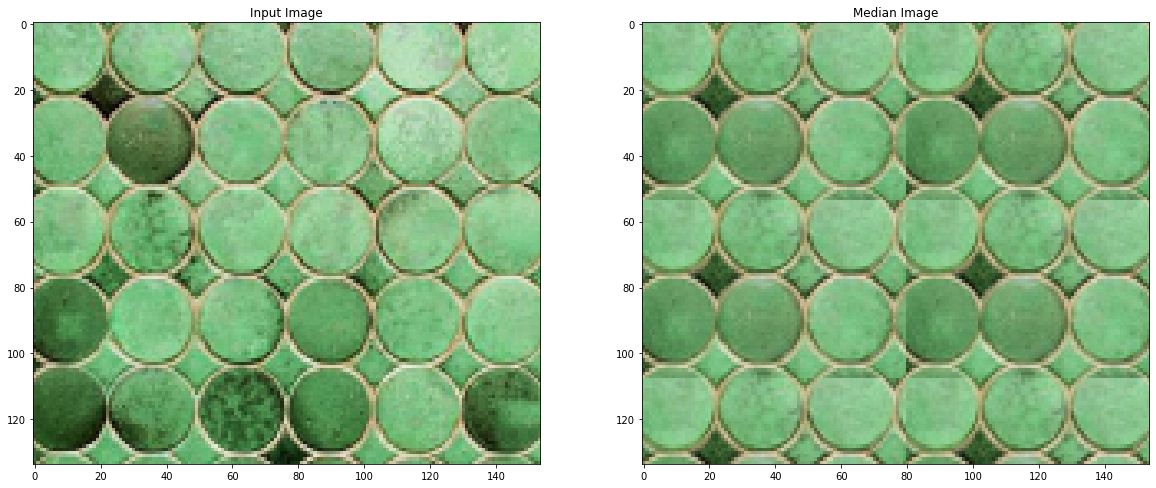

In [67]:
temp1=intact_texture('texture2.png')

In [ ]:
temp2=intact_texture('input.png')